# 导师制名企实训班商业智能方向 004期 Lesson 11

### Thinking 1: 常见的规划问题都包括哪些？

* 线性规划：研究线性约束条件下线性目标函数的极值问题
* 整数线性规划:全部决策变量必须为整数
* 混合整数规划:部分的决策变量是整数（不要求全部都是整数）
* 车辆路径问题

### Thinking 2: 常用的规划工具包都有哪些？

* pulp  
只用于线性模型，包括如整数规划、01规划，还是混合整数线性规划 MILP    
使用起来比较符合直觉
* ortools  
Google开发，用于优化的开源软件  
可以解决车辆路径、流程、整数和线性规划等问题  
提供了C++,Python,Java,.NET接口  

### Thinking 3: RFM模型的原理是怎样的

* Recency，最近一次消费时间间隔
* Frequency，消费频率，一段时间（比如1年）内的消费次数
* Monetary，消费金额，一段时间（比如1年）内的消费金额  
每个指标越大=>用户价值越高，用3个指标作为XYZ坐标轴，将空间分成8个部分进行分析 
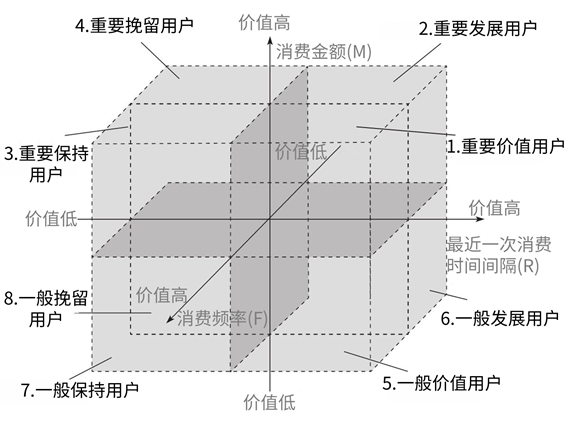
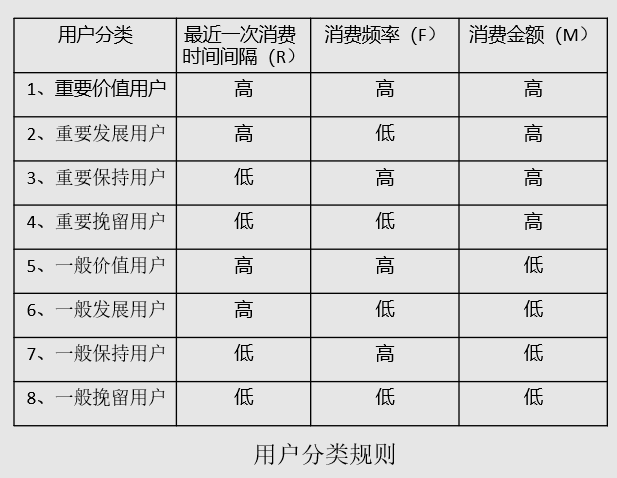

### Action 1: 智能供应链分析
数据集：SupplyChainDataset.csv，供应链采购数据  
To Do：  
对于欺诈订单进行预测，即Order Status='SUSPECTED_FRAUD'  
对于迟交货订单进行预测，即Delivery Status= 'Late delivery'  
对于销售额进行预测，即Sales字段  
对于订货数量进行预测，即Order Item Quantity  

In [1]:
# 引包
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")  # 忽略版本问题

In [2]:
# 数据加载
data = pd.read_csv('data/SupplyChain.csv', encoding='unicode_escape')
data.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [3]:
# 将firstname 与 lasename合并
data['Customer Full Name'] = data['Customer Fname'] + data['Customer Lname']
data[['Customer Full Name', 'Customer Fname', 'Customer Lname']]

,Customer Full Name,Customer Fname,Customer Lname
0,CallyHolloway,Cally,Holloway
1,IreneLuna,Irene,Luna
2,GillianMaldonado,Gillian,Maldonado
3,TanaTate,Tana,Tate
4,OrliHendricks,Orli,Hendricks
...,...,...,...
180514,MariaPeterson,Maria,Peterson
180515,RonaldClark,Ronald,Clark
180516,JohnSmith,John,Smith
180517,MarySmith,Mary,Smith


In [4]:
# 空值用0进行填充
data['Customer Zipcode'] = data['Customer Zipcode'].fillna(0)
train_data = data

### 预测

构造人工特征

In [5]:
train_data['fraud'] = np.where(train_data['Order Status']=='SUSPECTED_FRAUD', 1, 0)
train_data['fraud']

0         0
1         0
2         0
3         0
4         0
         ..
180514    0
180515    0
180516    0
180517    0
180518    0
Name: fraud, Length: 180519, dtype: int64

In [6]:
train_data['late_delivery'] = np.where(train_data['Delivery Status'] == 'Late delivery', 1, 0)
train_data['late_delivery']

0         0
1         1
2         0
3         0
4         0
         ..
180514    0
180515    1
180516    1
180517    0
180518    0
Name: late_delivery, Length: 180519, dtype: int64

In [7]:
categorical_cols = train_data.select_dtypes(include='object').columns
categorical_cols

Index(['Type', 'Delivery Status', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Email', 'Customer Fname',
       'Customer Lname', 'Customer Password', 'Customer Segment',
       'Customer State', 'Customer Street', 'Department Name', 'Market',
       'Order City', 'Order Country', 'order date (DateOrders)',
       'Order Region', 'Order State', 'Order Status', 'Product Image',
       'Product Name', 'shipping date (DateOrders)', 'Shipping Mode',
       'Customer Full Name'],
      dtype='object')

In [8]:
train_data['order date (DateOrders)'] = pd.to_datetime(train_data['order date (DateOrders)'], format='%m/%d/%Y %H:%M')
min_date = train_data['order date (DateOrders)'].min()
train_data['days_diff'] = (train_data['order date (DateOrders)'] - min_date).dt.days
train_data['days_diff']

0         1126
1         1108
2         1108
3         1108
4         1108
          ... 
180514     380
180515     380
180516     379
180517     379
180518     379
Name: days_diff, Length: 180519, dtype: int64

In [9]:
train_data.columns

Index(['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Delivery Status',
       'Late_delivery_risk', 'Category Id', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Email', 'Customer Fname', 'Customer Id',
       'Customer Lname', 'Customer Password', 'Customer Segment',
       'Customer State', 'Customer Street', 'Customer Zipcode',
       'Department Id', 'Department Name', 'Latitude', 'Longitude', 'Market',
       'Order City', 'Order Country', 'Order Customer Id',
       'order date (DateOrders)', 'Order Id', 'Order Item Cardprod Id',
       'Order Item Discount', 'Order Item Discount Rate', 'Order Item Id',
       'Order Item Product Price', 'Order Item Profit Ratio',
       'Order Item Quantity', 'Sales', 'Order Item Total',
       'Order Profit Per Order', 'Order Region', 'Order State', 'Order Status',
       'Order Zipcode', 'Product Card Id', 'Product Category Id',
       'Product De

In [10]:
train_data.drop(['Customer Email', 'Customer Password', 'Product Description', \
                 'Product Status', 'Product Image', 'Customer Fname',  \
                 'Customer Lname', 'Order Customer Id', 'Order Item Cardprod Id', \
                 'Order Item Id', 'Sales per customer', 'Order Item Total', \
                 'Order Profit Per Order', 'Product Card Id', \
                 'Product Category Id', 'Product Price', 'Order Zipcode', \
                 'order date (DateOrders)', 'Latitude', 'Longitude', \
                 'Customer Street', 'Order Status', \
                 'Delivery Status', 'Late_delivery_risk'], axis=1, inplace=True)
len(train_data.columns)

33

In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Category Id                    180519 non-null  int64  
 5   Category Name                  180519 non-null  object 
 6   Customer City                  180519 non-null  object 
 7   Customer Country               180519 non-null  object 
 8   Customer Id                    180519 non-null  int64  
 9   Customer Segment               180519 non-null  object 
 10  Customer State                 180519 non-null  object 
 11  Customer Zipcode               180519 non-null  float64
 12  Department Id                 

In [12]:
# 查看分类类型
categorical_cols = train_data.select_dtypes(include='object').columns
categorical_cols

Index(['Type', 'Category Name', 'Customer City', 'Customer Country',
       'Customer Segment', 'Customer State', 'Department Name', 'Market',
       'Order City', 'Order Country', 'Order Region', 'Order State',
       'Product Name', 'shipping date (DateOrders)', 'Shipping Mode',
       'Customer Full Name'],
      dtype='object')

In [13]:
train_data = train_data.dropna(subset=['Customer Full Name'])

In [14]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for cat in categorical_cols:
    train_data[cat] = le.fit_transform(train_data[cat])
train_data[categorical_cols]

,Type,Category Name,Customer City,Customer Country,Customer Segment,Customer State,Department Name,Market,Order City,Order Country,Order Region,Order State,Product Name,shipping date (DateOrders),Shipping Mode,Customer Full Name
0,1,40,66,1,0,36,4,3,331,70,15,475,78,27142,3,1875
1,3,40,66,1,0,36,4,3,391,69,13,841,78,2208,3,5374
2,0,40,452,0,0,5,4,3,391,69,13,841,78,1979,3,4426
3,1,40,285,0,2,5,4,3,3226,8,11,835,78,1751,3,12922
4,2,40,66,1,1,36,4,3,3226,8,11,835,78,1527,3,10632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180514,0,18,59,0,2,31,3,3,2922,31,7,913,24,2732,3,8421
180515,1,18,26,0,1,5,3,3,1362,77,7,770,24,2338,2,11672
180516,3,18,55,0,1,7,3,3,25,8,11,88,24,2726,3,6296
180517,2,18,66,1,0,36,3,3,25,8,11,88,24,2113,3,9379


In [15]:
# 得到所有数值类型
numerical_columns = train_data.columns.tolist()
for x in categorical_cols.tolist():
    numerical_columns.remove(x)
numerical_columns

['Days for shipping (real)',
 'Days for shipment (scheduled)',
 'Benefit per order',
 'Category Id',
 'Customer Id',
 'Customer Zipcode',
 'Department Id',
 'Order Id',
 'Order Item Discount',
 'Order Item Discount Rate',
 'Order Item Product Price',
 'Order Item Profit Ratio',
 'Order Item Quantity',
 'Sales',
 'fraud',
 'late_delivery',
 'days_diff']

### 分类任务预测
对于欺诈订单进行预测，即Order Status='SUSPECTED_FRAUD'   
对于迟交货订单进行预测，即Delivery Status= 'Late delivery'

In [16]:
train_data.columns

Index(['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Category Id', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Id', 'Customer Segment', 'Customer State',
       'Customer Zipcode', 'Department Id', 'Department Name', 'Market',
       'Order City', 'Order Country', 'Order Id', 'Order Item Discount',
       'Order Item Discount Rate', 'Order Item Product Price',
       'Order Item Profit Ratio', 'Order Item Quantity', 'Sales',
       'Order Region', 'Order State', 'Product Name',
       'shipping date (DateOrders)', 'Shipping Mode', 'Customer Full Name',
       'fraud', 'late_delivery', 'days_diff'],
      dtype='object')

In [17]:
# fraud数据集
x_fraud = train_data.loc[:, train_data.columns!='fraud']
y_fraud = train_data.loc[:, 'fraud']
# late数据集
x_late = train_data.loc[:,  train_data.columns!='late_delivery']
y_late = train_data.loc[:, 'late_delivery']

In [18]:
from sklearn.model_selection import train_test_split
# fraud数据集切分
x_fraud_train, x_fraud_test, y_fraud_train, y_fraud_test = train_test_split(x_fraud, y_fraud, test_size=0.2)
# late数据集切分
x_late_train, x_late_test, y_late_train, y_late_test = train_test_split(x_late, y_late, test_size=0.2)

In [19]:
pd.set_option('display.max_columns', None)
x_fraud_train

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Category Id,Category Name,Customer City,Customer Country,Customer Id,Customer Segment,Customer State,Customer Zipcode,Department Id,Department Name,Market,Order City,Order Country,Order Id,Order Item Discount,Order Item Discount Rate,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Region,Order State,Product Name,shipping date (DateOrders),Shipping Mode,Customer Full Name,late_delivery,days_diff
155819,2,6,4,-67.820000,17,12,66,1,11627,0,36,725.0,4,0,3,1694,31,25215,15.00,0.05,59.990002,-0.24,5,299.950012,7,1069,71,258,3,9379,1,368
18083,0,6,2,10.460000,17,12,559,0,11157,1,35,17402.0,4,0,2,3044,17,59660,1.20,0.02,59.990002,0.18,1,59.990002,12,237,71,41456,2,9379,1,870
47372,2,5,4,21.600000,17,12,169,0,12038,1,10,33312.0,4,0,3,2238,69,21239,7.20,0.04,59.990002,0.13,3,179.970001,13,39,71,12991,3,10774,1,310
83854,1,4,4,29.059999,18,34,461,0,11459,0,5,92703.0,4,0,2,2851,42,56003,19.50,0.15,129.990005,0.26,1,129.990005,3,886,56,33478,3,9379,0,817
95676,1,2,4,-25.780001,17,12,117,0,9190,0,40,75231.0,4,0,2,1271,102,5151,1.20,0.01,59.990002,-0.22,2,119.980003,3,470,71,29902,3,693,0,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64621,1,2,2,-8.270000,24,47,136,0,6700,0,40,78852.0,5,6,2,2347,102,54066,6.00,0.12,50.000000,-0.19,1,50.000000,3,1030,59,30188,2,13401,0,789
99729,1,1,0,69.089996,46,30,440,0,10741,0,24,63123.0,7,3,4,3173,48,39184,6.00,0.04,49.980000,0.48,3,149.940002,21,249,67,51447,1,4287,1,571
48696,1,6,2,4.690000,40,0,285,0,7340,1,5,90016.0,6,8,2,2484,38,51545,6.25,0.25,24.990000,0.25,1,24.990000,1,805,90,4640,2,2344,1,752
103160,3,2,4,-158.089996,48,46,66,1,2205,1,36,725.0,7,3,1,2700,75,18621,14.00,0.07,199.990005,-0.85,1,199.990005,17,565,70,7031,3,13466,0,271


In [20]:
from sklearn.preprocessing import StandardScaler
# 数据规范化
sc = StandardScaler()
# fraud
x_fraud_train = sc.fit_transform(x_fraud_train)
x_fraud_test = sc.transform(x_fraud_test)
# late
x_late_train = sc.fit_transform(x_late_train)
x_late_test = sc.transform(x_late_test)

In [21]:
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix, f1_score
def model_stats(model, x_train, x_test, y_train, y_test, name='Fraud'):
    model = model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_pred, y_test)
    recall = recall_score(y_pred, y_test)
    auc = roc_auc_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test)
    confusion = confusion_matrix(y_pred, y_test)
    print('Model Used:', model)
    print('{} Accuracy: {}%'.format(name, accuracy*100))
    print('{} Recall: {}%'.format(name, recall*100))
    print('{} AUC: {}%'.format(name, auc*100))
    print('{} F1 Score: {}%'.format(name, f1*100))
    print('{} Confusion Matrix:\n {}'.format(name, confusion))
    return model, accuracy, recall, auc, f1

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import LinearSVC
model_list = [LogisticRegression(), GaussianNB(), LinearSVC(), DecisionTreeClassifier()]

In [23]:
models_accuary = pd.DataFrame(np.zeros([len(model_list), 2]), index=model_list, columns=['fraud', 'late'])
models_recall = pd.DataFrame(np.zeros([len(model_list), 2]), index=model_list, columns=['fraud', 'late'])
models_auc = pd.DataFrame(np.zeros([len(model_list), 2]), index=model_list, columns=['fraud', 'late'])
models_f1 = pd.DataFrame(np.zeros([len(model_list), 2]), index=model_list, columns=['fraud', 'late'])

In [24]:
for model in model_list:
    _, acc, recall, auc, f1 = model_stats(model, x_fraud_train, x_fraud_test, y_fraud_train, y_fraud_test, 'Fraud')
    models_accuary.loc[model, 'fraud'] = acc
    models_recall.loc[model, 'fraud'] = recall
    models_auc.loc[model, 'fraud'] = auc
    models_f1.loc[model, 'fraud'] = f1
    _, acc, recall, auc, f1 = model_stats(model, x_late_train, x_late_test, y_late_train, y_late_test, 'Late Delivery')
    models_accuary.loc[model, 'late'] = acc
    models_recall.loc[model, 'late'] = recall
    models_auc.loc[model, 'late'] = auc
    models_f1.loc[model, 'late'] = f1

Model Used: LogisticRegression()
Fraud Accuracy: 97.79796692795613%
Fraud Recall: 52.32558139534884%
Fraud AUC: 75.2804953314729%
Fraud F1 Score: 31.16883116883117%
Fraud Confusion Matrix:
 [[35128   631]
 [  164   180]]
Model Used: LogisticRegression()
Late Delivery Accuracy: 98.84220147910145%
Late Delivery Recall: 97.93345528254314%
Late Delivery AUC: 98.96672764127158%
Late Delivery F1 Score: 98.95593965431112%
Late Delivery Confusion Matrix:
 [[15876     0]
 [  418 19809]]
Model Used: GaussianNB()
Fraud Accuracy: 87.93175082403124%
Fraud Recall: 15.692724458204335%
Fraud AUC: 57.84636222910217%
Fraud F1 Score: 27.128282321458443%
Fraud Confusion Matrix:
 [[30935     0]
 [ 4357   811]]
Model Used: GaussianNB()
Late Delivery Accuracy: 57.20300252056616%
Late Delivery Recall: 56.1805082822782%
Late Delivery AUC: 77.97219038671172%
Late Delivery F1 Score: 71.94043403250704%
Late Delivery Confusion Matrix:
 [[  845     2]
 [15449 19807]]
Model Used: LinearSVC()
Fraud Accuracy: 97.74533

In [25]:
models_accuary

,fraud,late
LogisticRegression(),0.977980,0.988422
GaussianNB(),0.879318,0.572030
LinearSVC(),0.977453,0.988422
DecisionTreeClassifier(),0.992328,0.993463


In [26]:
models_recall

,fraud,late
LogisticRegression(),0.523256,0.979335
GaussianNB(),0.156927,0.561805
LinearSVC(),0.495082,0.979335
DecisionTreeClassifier(),0.838832,0.993993


In [27]:
models_auc

,fraud,late
LogisticRegression(),0.752805,0.989667
GaussianNB(),0.578464,0.779722
LinearSVC(),0.738323,0.989667
DecisionTreeClassifier(),0.917293,0.993406


In [28]:
models_f1

,fraud,late
LogisticRegression(),0.311688,0.989559
GaussianNB(),0.271283,0.719404
LinearSVC(),0.270609,0.989559
DecisionTreeClassifier(),0.826767,0.994043


In [29]:
# 决策树模型
# fraud
model_fraud = DecisionTreeClassifier()
print(model_stats(model_fraud, x_fraud_train, x_fraud_test, y_fraud_train, y_fraud_test, 'Fraud'))
# late
model_late = DecisionTreeClassifier()
print(model_stats(model_late, x_late_train, x_late_test, y_late_train, y_late_test, 'Late Delivery'))

Model Used: DecisionTreeClassifier()
Fraud Accuracy: 99.1912029471235%
Fraud Recall: 82.72383354350568%
Fraud AUC: 91.14243220647388%
Fraud F1 Score: 81.79551122194515%
Fraud Confusion Matrix:
 [[35155   155]
 [  137   656]]
(DecisionTreeClassifier(), 0.991912029471235, 0.8272383354350568, 0.9114243220647388, 0.8179551122194515)
Model Used: DecisionTreeClassifier()
Late Delivery Accuracy: 99.36847353405534%
Late Delivery Recall: 99.41452581638318%
Late Delivery AUC: 99.3634937246434%
Late Delivery F1 Score: 99.424562111958%
Late Delivery Confusion Matrix:
 [[16178   112]
 [  116 19697]]
(DecisionTreeClassifier(), 0.9936847353405535, 0.9941452581638318, 0.993634937246434, 0.9942456211195799)


In [30]:
# 根据决策树模型，得到feature importance
important_col = model_fraud.feature_importances_.argsort()
feat_importance = pd.DataFrame({'features':x_fraud.columns[important_col], 'importance':model_fraud.feature_importances_[important_col]})
feat_importance

,features,importance
0,Customer Country,0.000974
1,Department Name,0.001899
2,Category Name,0.002193
3,Order Item Quantity,0.002275
4,Department Id,0.003022
5,Category Id,0.003572
6,Order Item Product Price,0.004431
7,Order Item Discount Rate,0.004921
8,Order Item Discount,0.005641
9,Customer Segment,0.006601


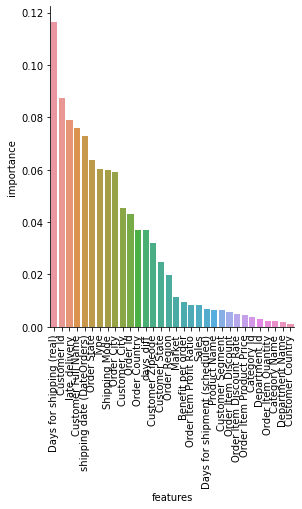

In [31]:
import seaborn as sns
feat_importance = feat_importance.sort_values(by='importance', ascending=False)
sns.catplot(x='features', y='importance', data=feat_importance, kind='bar')
plt.xticks(rotation=90)
plt.show()

In [46]:
# 根据决策树模型，得到feature importance
important_col = model_late.feature_importances_.argsort()
feat_importance = pd.DataFrame({'features':x_late.columns[important_col], 'importance':model_late.feature_importances_[important_col]})
feat_importance

,features,importance
0,Order Item Quantity,0.000084
1,Department Name,0.000101
2,Department Id,0.000143
3,Days for shipment (scheduled),0.000166
4,Category Name,0.000191
5,Category Id,0.000216
6,Order Item Product Price,0.000294
7,Product Name,0.000306
8,Order Item Discount,0.000323
9,Sales,0.000345


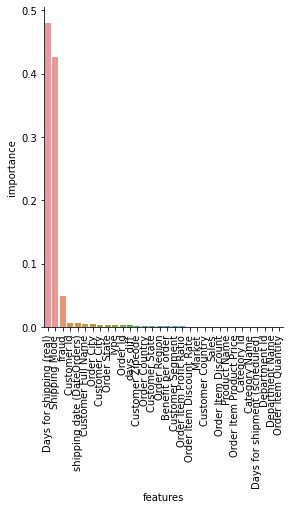

In [47]:
feat_importance = feat_importance.sort_values(by='importance', ascending=False)
sns.catplot(x='features', y='importance', data=feat_importance, kind='bar')
plt.xticks(rotation=90)
plt.show()

### 回归任务预测
对于销售额进行预测，即Sales字段  
对于订货数量进行预测，即Order Item Quantity  

In [50]:
train_data.columns

Index(['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Category Id', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Id', 'Customer Segment', 'Customer State',
       'Customer Zipcode', 'Department Id', 'Department Name', 'Market',
       'Order City', 'Order Country', 'Order Id', 'Order Item Discount',
       'Order Item Discount Rate', 'Order Item Product Price',
       'Order Item Profit Ratio', 'Order Item Quantity', 'Sales',
       'Order Region', 'Order State', 'Product Name',
       'shipping date (DateOrders)', 'Shipping Mode', 'Customer Full Name',
       'fraud', 'late_delivery', 'days_diff'],
      dtype='object')

In [32]:
# sales数据集
x_sales = train_data.loc[:,  train_data.columns!='Sales']
y_sales = train_data.loc[:, 'Sales']
# OIQ数据集
x_oiq = train_data.loc[:,  train_data.columns!='Order Item Quantity']
y_oiq = train_data.loc[:, 'Order Item Quantity']

In [33]:
# sqles数据集切分
x_sales_train, x_sales_test, y_sales_train, y_sales_test = train_test_split(x_sales, y_sales, test_size=0.2)
# OIQ数据集切分
x_oiq_train, x_oiq_test, y_oiq_train, y_oiq_test = train_test_split(x_oiq, y_oiq, test_size=0.2)

In [34]:
# sales
x_sales_train = sc.fit_transform(x_sales_train)
x_sales_test = sc.transform(x_sales_test)
# OIQ
x_oiq_train = sc.fit_transform(x_oiq_train)
x_oiq_test = sc.transform(x_oiq_test)

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def model_stats_r(model, x_train, x_test, y_train, y_test, name='Sales'):
    model = model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    mae = mean_absolute_error(y_pred, y_test)
    mse = mean_squared_error(y_pred, y_test)
    r2 = r2_score(y_pred, y_test)
    print('Model Used:', model)
    print('{} MAE: {}'.format(name, mae))
    print('{} MSE: {}'.format(name, mse))
    print('{} R2 Score: {}'.format(name, r2))
    return model, mae, mse, r2

In [36]:
from sklearn.linear_model import LinearRegression
# 线性回归模型
# sales
model_sales = LinearRegression()
print(model_stats_r(model_sales, x_sales_train, x_sales_test, y_sales_train, y_sales_test, 'Sales'))
# OIQ
model_oiq = LinearRegression()
print(model_stats_r(model_oiq, x_oiq_train, x_oiq_test, y_oiq_train, y_oiq_test, 'Order Item Quantity'))

Model Used: LinearRegression()
Sales MAE: 18.39443915108247
Sales MSE: 948.4193588570378
Sales R2 Score: 0.9448942357832889
(LinearRegression(), 18.39443915108247, 948.4193588570378, 0.9448942357832889)
Model Used: LinearRegression()
Order Item Quantity MAE: 0.3493036453018201
Order Item Quantity MSE: 0.2871744822107154
Order Item Quantity R2 Score: 0.8430607065973148
(LinearRegression(), 0.3493036453018201, 0.2871744822107154, 0.8430607065973148)


In [37]:
model_list = [LinearRegression(), DecisionTreeRegressor()]

In [38]:
models_mae = pd.DataFrame(np.zeros([len(model_list), 2]), index=model_list, columns=['sales', 'oiq'])
models_mse = pd.DataFrame(np.zeros([len(model_list), 2]), index=model_list, columns=['sales', 'oiq'])
models_r2 = pd.DataFrame(np.zeros([len(model_list), 2]), index=model_list, columns=['sales', 'oiq'])

In [39]:
for model in model_list:
    _, mae, mse, r2 = model_stats_r(model, x_sales_train, x_sales_test, y_sales_train, y_sales_test, 'Sales')
    models_mae.loc[model, 'sales'] = mae
    models_mse.loc[model, 'sales'] = mse
    models_r2.loc[model, 'sales'] = r2
    _, mae, mse, r2 = model_stats_r(model, x_oiq_train, x_oiq_test, y_oiq_train, y_oiq_test, 'Order Item Quantity')
    models_mae.loc[model, 'oiq'] = mae
    models_mse.loc[model, 'oiq'] = mse
    models_r2.loc[model, 'oiq'] = r2

Model Used: LinearRegression()
Sales MAE: 18.39443915108247
Sales MSE: 948.4193588570378
Sales R2 Score: 0.9448942357832889
Model Used: LinearRegression()
Order Item Quantity MAE: 0.3493036453018201
Order Item Quantity MSE: 0.2871744822107154
Order Item Quantity R2 Score: 0.8430607065973148
Model Used: DecisionTreeRegressor()
Sales MAE: 8.490799313370018e-12
Sales MSE: 1.348741639910077e-22
Sales R2 Score: 1.0
Model Used: DecisionTreeRegressor()
Order Item Quantity MAE: 0.0
Order Item Quantity MSE: 0.0
Order Item Quantity R2 Score: 1.0


In [40]:
models_mae

,sales,oiq
LinearRegression(),1.839444e+01,0.349304
DecisionTreeRegressor(),8.490799e-12,0.000000


In [41]:
models_mse

,sales,oiq
LinearRegression(),9.484194e+02,0.287174
DecisionTreeRegressor(),1.348742e-22,0.000000


In [42]:
models_r2

,sales,oiq
LinearRegression(),0.944894,0.843061
DecisionTreeRegressor(),1.000000,1.000000


In [43]:
from sklearn.ensemble import GradientBoostingRegressor
# 梯度提升树模型
# sales
model_sales = GradientBoostingRegressor()
print(model_stats_r(model_sales, x_sales_train, x_sales_test, y_sales_train, y_sales_test, 'Sales'))
# OIQ
model_oiq = GradientBoostingRegressor()
print(model_stats_r(model_oiq, x_oiq_train, x_oiq_test, y_oiq_train, y_oiq_test, 'Order Item Quantity'))

Model Used: GradientBoostingRegressor()
Sales MAE: 2.0691733123208182
Sales MSE: 10.532956283403488
Sales R2 Score: 0.9994111209215912
(GradientBoostingRegressor(), 2.0691733123208182, 10.532956283403488, 0.9994111209215912)
Model Used: GradientBoostingRegressor()
Order Item Quantity MAE: 0.03652222485172941
Order Item Quantity MSE: 0.004609012804982951
Order Item Quantity R2 Score: 0.9977933412977923
(GradientBoostingRegressor(), 0.03652222485172941, 0.004609012804982951, 0.9977933412977923)


In [44]:
# 根据树模型，得到feature importance
important_col = model_sales.feature_importances_.argsort()
feat_importance = pd.DataFrame({'features':x_sales.columns[important_col], 'importance':model_sales.feature_importances_[important_col]})
feat_importance

,features,importance
0,Type,0.000000
1,fraud,0.000000
2,Customer Full Name,0.000000
3,Shipping Mode,0.000000
4,shipping date (DateOrders),0.000000
5,Order State,0.000000
6,Order Region,0.000000
7,Order Country,0.000000
8,late_delivery,0.000000
9,Market,0.000000


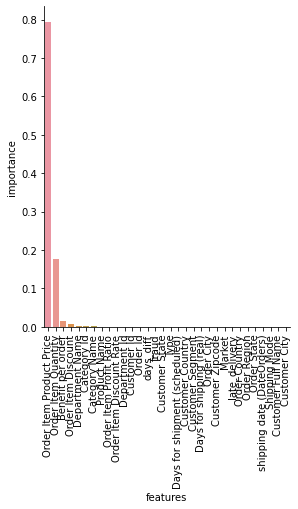

In [45]:
feat_importance = feat_importance.sort_values(by='importance', ascending=False)
sns.catplot(x='features', y='importance', data=feat_importance, kind='bar')
plt.xticks(rotation=90)
plt.show()

In [48]:
# 根据树模型，得到feature importance
important_col = model_oiq.feature_importances_.argsort()
feat_importance = pd.DataFrame({'features':x_oiq.columns[important_col], 'importance':model_oiq.feature_importances_[important_col]})
feat_importance

,features,importance
0,Order City,-3.075289e-19
1,fraud,0.000000e+00
2,Customer Full Name,0.000000e+00
3,Shipping Mode,0.000000e+00
4,Order Region,0.000000e+00
5,Order Item Profit Ratio,0.000000e+00
6,Order Item Discount Rate,0.000000e+00
7,Order Item Discount,0.000000e+00
8,Order Country,0.000000e+00
9,late_delivery,0.000000e+00


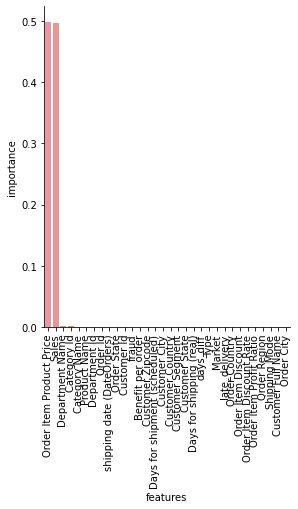

In [49]:
feat_importance = feat_importance.sort_values(by='importance', ascending=False)
sns.catplot(x='features', y='importance', data=feat_importance, kind='bar')
plt.xticks(rotation=90)
plt.show()

### Action 2: 一个农民承包了6块耕地共300亩，准备播种小麦，玉米，水果和蔬菜四种农产品，已知各种农产品的计划播种面积、每块土地种植不同农产品的单产收益
如何进行合理安排，使得总收益最大  
可以使用pulp/ortools工具  
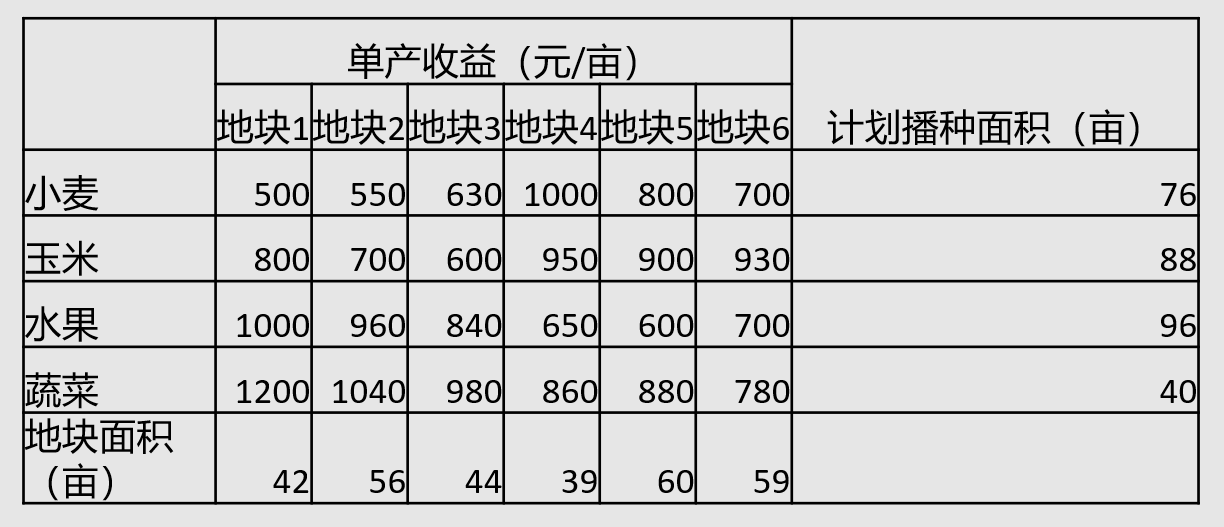

In [56]:
import pulp

In [52]:
# 单产收益 （元/亩）
costs = np.array([[500, 550, 630, 1000, 800, 700],
                  [800, 700, 600, 950, 900, 930],
                  [1000, 960, 840, 650, 600, 700],
                  [1200, 1040, 980, 860, 880, 780]])

In [53]:
# 计划播种面积（亩）
max_plant = [76, 88, 96, 40]

In [54]:
# 地块面积（亩）
max_cultivation = [42, 56, 44, 39, 60, 59]

In [76]:
# 定义问题
def farming_problem(costs, x_max, y_max):
    row = len(costs)
    col = len(costs[0])
    # 定义问题
    prob = pulp.LpProblem('Farming', sense=pulp.LpMaximize)
    # 定义决策变量
    var = [[pulp.LpVariable(f'x{i}{j}', lowBound=0, cat=pulp.LpInteger)
           for j in range(col)] for i in range(row)]
    # 递归展开列表
    flatten = lambda x: [y for l in x for y in flatten(l)] if type(x) is list else [x]
    # 定义目标函数
    prob += pulp.lpDot(flatten(var), costs.flatten())
    # 定义约束条件
    for i in range(row):
        prob += pulp.lpSum(var[i]) <= x_max[i]
    for j in range(col):
        prob += pulp.lpSum([var[i][j] for i in range(row)]) <= y_max[j]
    # 求解问题
    prob.solve()
    # 封装结果
    result = {'obj':pulp.value(prob.objective),
             'var':[[pulp.value(var[i][j]) for j in range(col)] for i in range(row)]}
    return result, prob


In [77]:
# 使用线性规划
result, prob = farming_problem(costs, max_plant, max_cultivation)

In [85]:
# 输出结果
print(f'求解状态：{pulp.LpStatus[prob.status]}')
print(f'最大值为{result["obj"]}')
print('各变量的取值为：')
pd.DataFrame(result['var'], 
             index=['小麦', '玉米', '水果', '蔬菜'], 
             columns=['地块1', '地块2', '地块3', '地块4', '地块5', '地块6'])

求解状态：Optimal
最大值为284230.0
各变量的取值为：


,地块1,地块2,地块3,地块4,地块5,地块6
小麦,0.0,0.0,6.0,39.0,31.0,0.0
玉米,0.0,0.0,0.0,0.0,29.0,59.0
水果,2.0,56.0,38.0,0.0,0.0,0.0
蔬菜,40.0,0.0,0.0,0.0,0.0,0.0
